# Learning as Conditional Inference

March 2015  
[Wannes Meert](mailto:wannes.meert@cs.kuleuven.be)  
[Anton Dries](mailto:anton.dries@cs.kuleuven.be)

Based on [Church](http://projects.csail.mit.edu/church/wiki/Church)'s [ProbMods book](https://probmods.org/learning-as-conditional-inference.html).

In [1]:
import sys, os, imp

sys.path.append(os.path.abspath('../..'))
sys.path.append(os.path.abspath('../../examples'))
sys.path.append(os.path.abspath('../../util'))

%load_ext problog.magic

In this notebook we will make use of the `problogmagic` extension for IPython to format results. All code can also be ran as

    $ ./problog-cli.py path/to/file.pl

Or in a Notebook without the magic extensions (but `problog-cli.py` in your path:

    %%script problog-cli.py
    ... rest of cell

## Example: Learning About Coins

This example computes the probability that it is a fair coin give a sequence of observations. What it computes is Bayes' rule:
\begin{equation*}
    Pr(fair \mid data) = \frac{Pr(data \mid fair) \cdot Pr(fair)}{Pr(data)}
\end{equation*}

with $Pr(data \mid fair)$ the expression that is modelled by the ProbLog program. And $Pr(fair \mid data)$ is asked for using the `query/1` and `evidence/2` predicates.

In [2]:
%%problog

%% Prior
0.999::fair_coin.
%% Normal and biased coin
0.50::coin(h,T) ; 0.50::coin(t,T) :-   fair_coin.
0.95::coin(h,T) ; 0.05::coin(t,T) :- \+fair_coin.

%% Probability of a sequence of coin tosses
tosses(Cs) :- tosses(Cs,0).
tosses([],T).
tosses([C|R],T) :-
    coin(C,T),
    Tn is T + 1,
    tosses(R,Tn).

%% What is the observed sequence of coin tosses?
%evidence(tosses([h,h,h,h,h]), true).
%evidence(tosses([h,h,h,h,h,h,h,h,h,h]), true).
evidence(tosses([h,h,h,h,h,h,h,h,h,h,h,h,h,h,h]), true).

query(fair_coin).

Atom Probability fair_coin 0.0617

It is important to have a `T` argument in `coin/2` to indicate about which coin we are talking. Coins are independent of each other but the same coin could be fair or not. And it is important the system knows you are talking about the same coin.

## Learning a Continuous Parameter

Suppose that the probability of how much the coin is biased is a continuous number. What is the posterior distribution over this probability given a sequence of observations. This result can be used to update our prior belief over the bias of the coin.

In [20]:
%%problog

%% Uniform prior on coin weights (cw)
%% Discretised for ProbLog (TODO: can we do better?)
P::cw(0) ; P::cw(0.25) ; P::cw(0.5) ; P::cw(0.75) ; P::cw(1.0) :- P is 1.0/5.
%% Normal and biased coin
Ph::coin(h,T) ; Pt::coin(t,T) :- cw(Ph), Pt is 1.0-Ph.

%% Probability of a sequence of coin tosses
tosses(Cs) :- tosses(Cs,0).
tosses([],T).
tosses([C|R],T) :-
    coin(C,T),
    Tn is T + 1,
    tosses(R,Tn).

%% What is the observed sequence of coin tosses?
evidence(tosses([h,h,h,h,h]), true).

query(cw(V)).

Atom Prob cw(0) 0.0000 cw(0.25) 0.0008 cw(0.5) 0.0246 cw(0.75) 0.1869 cw(1.0) 0.7877

### Bayesian Learning

We can integrate Bayesian learning into the ProbLog system by combining ProbLog and Python.

#### Sampling

First, we can sample from a simple program to generate data:

In [14]:
%%problogsample -N 10

0.9::coin(h) ; 0.1::coin(t).

query(coin(S)).

coin(h). % Probability: 0.9 coin(h). % Probability: 0.9 coin(t). % Probability: 0.1 coin(h). % Probability: 0.9 coin(h). % Probability: 0.9 coin(h). % Probability: 0.9 coin(h). % Probability: 0.9 coin(h). % Probability: 0.9 coin(h). % Probability: 0.9 coin(h). % Probability: 0.9

Or we can sample a list of random length (stop probability is 0.1):

In [15]:
%%problogsample -N 1

0.9::coin(h,T) ; 0.1::coin(t,T).

0.1::stop(T).

tosses(C) :- tosses(C,0).
tosses([],T) :- stop(T).
tosses([H|R],T) :- \+stop(T), coin(H,T), Tn is T+1, tosses(R,Tn).

query(tosses(C)).

tosses([h, h, h, h, h, t, h, h, h, h, h, h, h, h, h, h, h, h, h, h, h, h, h, h, h, h, h, h, h, h]). % Probability: 1.9966781e-05

#### Learn

Then we can sample an increasing number of samples to apply the same Bayesian rule approach as above and see the accuracy of our estimation improve:

In [16]:
model_str = """
P::cw(0); P::cw(0.125); P::cw(0.25); P::cw(0.375); P::cw(0.5); P::cw(0.625); P::cw(0.75);P::cw(0.875); P::cw(1.0) :- P is 1.0/9.
Ph::coin(h,T) ; Pt::coin(t,T) :- cw(Ph), Pt is 1.0-Ph.

tosses(Cs) :- tosses(Cs,0).
tosses([],T).
tosses([C|R],T) :-
    coin(C,T),
    Tn is T + 1,
    tosses(R,Tn).

query(cw(V)).

"""

sample_str = """
0.9::coin(h) ; 0.1::coin(t).

query(coin(S)).
"""

Sampled observations: [h]
Sampled observations: [t, h]
Sampled observations: [h, t, h]
Sampled observations: [h, h, h, h]
Sampled observations: [h, h, h, h, t]
Sampled observations: [h, h, h, h, h, t]


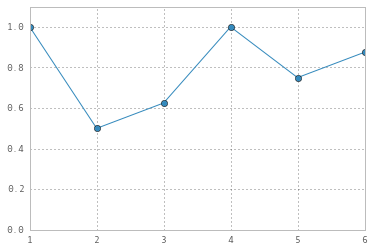

In [17]:
from problog.core import ProbLog
from problog.program import PrologString
import example_sampling_alt as plsample # TODO: make part of problog package?
from problog.sdd_formula import SDD

import matplotlib.pyplot as plt
%matplotlib inline

#sizes = [1, 3, 6, 10, 20, 30, 50, 70, 100] # TODO: sizes > 6 are really slow
sizes = [1, 2, 3, 4, 5, 6]
results = []

for observed_data_size in sizes:
    model = PrologString(sample_str)
    samples,_ = plsample.sample_object(model, N=observed_data_size)
    observations = [list(sample.queries())[0][0].args[0] for sample in samples]
    print('Sampled observations: {}'.format(observations))
    observations_str = "evidence(tosses({})).\n".format(observations)
    model = PrologString(model_str+observations_str)
    
    nnf = ProbLog.convert(model, SDD)
    outcome = nnf.evaluate()
    
    results.append(max([(atom.args[0],prob) for atom,prob in outcome.items()], key=lambda t:t[1]))

plt.plot(sizes, [result[0] for result in results], marker='o');
a = plt.gca()
a.set_ylim([0,1.1]);

### Beta prior



The prior (discretized):

In [7]:
%%problog

:- load_external('beta.py').

%% Prior on coin weights (cw)
%% TODO: make better/easier
P0::cw(0) ; P25::cw(0.25) ; P50::cw(0.5) ; P75::cw(0.75) ; P100::cw(1.0) :-
    call_external(beta_pdf(10,10,[0.0,0.25,0.50,0.75,1.00]), R),
    [P0,P25,P50,P75,P100] = R.

query(cw(V)).

Atom Probability cw(0) 0.0000 cw(0.25) 0.0661 cw(0.5) 0.8810 cw(0.75) 0.0661 cw(1.0) 0.0000

The beta distribution is load from Python with:

In [45]:
!cat beta.py

from scipy.stats import beta

def beta_pdf(a, b, values):
    pdf = beta.pdf(values, a, b)
    return pdf.tolist()


*The discretisation is ugly now.*

**TODO**: figure out easier syntax/method

<div style="background-color:#FB9496;margin:5px 0;padding:3px;">Proposal:</div>

    _::cw(_) :- call_external(beta_pdf(10,10,0.25), R), expandhead(R).

- beta_pdf returns binary tuples [(prob,real)]
- `expandhead/1` is a predicate that maps the head atom to the given list where the number of elements in a tuple match the underscores in the head atom.
- How similar is this internally to `P::a :- P is 1/2.` ?


And after observing evidence:

In [8]:
%%problog

:- load_external('beta.py').

%% Prior on coin weights (cw)
P0::cw(0) ; P25::cw(0.25) ; P50::cw(0.5) ; P75::cw(0.75) ; P100::cw(1.0) :-
    call_external(beta_pdf(10,10,[0.0,0.25,0.50,0.75,1.00]), R),
    [P0,P25,P50,P75,P100] = R.

%% Normal and biased coin
Ph::coin(h,T) ; Pt::coin(t,T) :- cw(Ph), Pt is 1.0-Ph.

%% Probability of a sequence of coin tosses
tosses(Cs) :- tosses(Cs,0).
tosses([],T).
tosses([C|R],T) :-
    coin(C,T),
    Tn is T + 1,
    tosses(R,Tn).

%% What is the observed sequence of coin tosses?
evidence(tosses([h,h,h,h,h]), true).

query(cw(V)).

Atom Probability cw(0) 0.0000 cw(0.25) 0.0015 cw(0.5) 0.6359 cw(0.75) 0.3626 cw(1.0) 0.0000

### Example: Estimating Causal Power

...

In [26]:
%%problog

%% causal power of C to cause E (prior)
P::cpw(0) ; P::cpw(0.25) ; P::cpw(0.5) ; P::cpw(0.75) ; P::cpw(1.0) :- P is 1.0/5.
%% background probability of E (prior)
P::bw(0) ; P::bw(0.25) ; P::bw(0.5) ; P::bw(0.75) ; P::bw(1.0) :- P is 1.0/5.

%P::cp(T) :- cpw(P).
%P::b(T) :- bw(P).
%e_if_c(C,T) :- cp(T), C=true.
%e_if_c(C,T) :- b(T).

P::e_if_c(C,T) :- cpw(P), C=true.
P::e_if_c(C,T) :- bw(P).

evidence(e_if_c(true,0),  true).
evidence(e_if_c(true,1),  true).
evidence(e_if_c(false,2), false).
evidence(e_if_c(true,3),  true).

query(cpw(V)).

Atom Probability cpw(0) 0.0355 cpw(0.25) 0.0660 cpw(0.5) 0.1355 cpw(0.75) 0.2695 cpw(1.0) 0.4935

We can express this more ProbLog like. This results in a much easier model to comprehend:

(Also slower, too many variables?)

In [27]:
%%problog

%% causal power of C to cause E (prior)
P::cpw(0) ; P::cpw(0.25) ; P::cpw(0.5) ; P::cpw(0.75) ; P::cpw(1.0) :- P is 1.0/5.
%% background probability of E (prior)
P::bw(0) ; P::bw(0.25) ; P::bw(0.5) ; P::bw(0.75) ; P::bw(1.0) :- P is 1.0/5.

0.5::c(T). % Prior on c. Will not be important because fully observed.

P::e(T) :- cpw(P), c(T).
P::e(T) :- bw(P).

evidence(c(0), true).
evidence(e(0), true).
evidence(e(1), true).
evidence(c(1), true).
evidence(e(2), false).
evidence(c(2), false).
evidence(e(3), true).
evidence(c(3), true).

query(cpw(V)).

Atom Probability cpw(0) 0.0355 cpw(0.25) 0.0660 cpw(0.5) 0.1355 cpw(0.75) 0.2695 cpw(1.0) 0.4935

## Grammar-based Concept Induction


### Example: Inferring an Arithmetic Expression

#### Pure ProbLog

Let's start with a version where we sample an arithmetic expressing using ProbLog and immediately compute the result of the expression (ignoring 'x'):

In [32]:
%%problogsample

0.7::leaf(T).

0.5::operator('+',T) ; 0.5::operator('-',T).

% x = 1
Px::l(1,T); P::l(0,T); P::l(1,T); P::l(2,T); P::l(3,T); P::l(4,T); P::l(5,T); P::l(6,T); P::l(7,T); P::l(8,T); P::l(9,T) :- Px = 0.5, P is (1-Px)/10.

expr(A,R) :- expr(A,1,S), R is A.

expr(L,T1,T2) :- leaf(T1), T2 is T1+1, l(L,T1).
expr(S,T1,T2) :-
   \+ leaf(T1),
   Ta is T1+1,
   expr(E1,Ta,Tb),
   expr(E2,Tb,T2),
   operator(Operator,Ta),
   S =.. [Operator,E1,E2].

query(expr(A,R)).

expr(1,1). % Probability: 0.35 expr(7,7). % Probability: 0.035 expr(1,1). % Probability: 0.35 expr('+'('+'('-'('-'(1,1),'+'(7,'+'('+'(1,1),5))),1),'+'(1,1)),-11). % Probability: 2.0199586e-13 expr(9,9). % Probability: 0.035

If you want to include the `x` variable and give it a value of 1:

In [44]:
%%problogsample -N 4

0.7::leaf(T).

0.5::operator('+',T) ; 0.5::operator('-',T).

Px::l(x,T); P::l(0,T) ; P::l(1,T) ; P::l(2,T) ; P::l(3,T) ; P::l(4,T) ; P::l(5,T) ; P::l(6,T) ; P::l(7,T) ; P::l(8,T) ; P::l(9,T) :- P is 0.5/10, Px is 0.5.

expr(L,R,X) :- expr(L,0,Tr,R,X).

expr(L,T,T,X,X) :- leaf(T), l(L,T), L = 'x'.
expr(L,T,T,L,X) :- leaf(T), l(L,T), L \== 'x'.

expr([L,O,R],T,Tr,Re,X) :-
    \+leaf(T), operator(O,T),
    Tn1 is T+1, expr(L,Tn1,Tr1,RL,X),
    Tn2 is Tr1+1, expr(R,Tn2,Tr,RR,X),
    (O == '+', Re is RL+RR;
     O == '-', Re is RL-RR).

query(expr(E,R,1)).

expr(5,5,1). % Probability: 0.035 expr([[5, '+', 5], '+', 6],16,1). % Probability: 9.646875e-07 expr(0,0,1). % Probability: 0.035 expr(4,4,1). % Probability: 0.035

#### ProbLog and Python combined

We can also use ProbLog to generate expressions that are Python expressions. If we call ProbLog from within a Python environment we can mix ProbLog and Python to achieve what we want:

In [41]:
model_str = """
0.7::leaf(T).

0.5::operator('+',T) ; 0.5::operator('-',T).

Px::l(x,T); P::l(0,T) ; P::l(1,T) ; P::l(2,T) ; P::l(3,T) ; P::l(4,T) ; P::l(5,T) ; P::l(6,T) ; P::l(7,T) ; P::l(8,T) ; P::l(9,T) :- P is 0.5/10, Px is 0.5.

expr(L) :- expr(L,0,Tr).

expr(L,T1,T2) :- leaf(T1), T2 is T1+1, l(L,T1).
expr([EL,O,ER],T1,T2) :-
    \+leaf(T1),
    Ta is T1+1, operator(O,Ta),
    expr(EL,Ta,Tb),
    expr(ER,Tb,T2).

query(expr(E)).
"""

In [42]:
from problog.program import PrologString
import example_sampling_alt as plsample
from problog.pypl import pl2py

model = PrologString(model_str)
samples, db = plsample.sample_object(model, N=10)
x = 1

def list2expr(l):
    if type(l) == list:
        return '({})'.format(''.join([list2expr(sl) for sl in l]))
    else:
        return str(l).replace("'",'')

for sample in samples:
    expr = list(sample.queries())[0][0].args[0]
    expr = list2expr(pl2py(expr))
    print('{} --> {}'.format(expr, eval(expr)))

x --> 1
x --> 1
((x+((x-(x-((x-x)-((x+9)+x))))-x))-7) --> -18
(x+0) --> 1
4 --> 4
x --> 1
(x-(((x-(((x-(x+6))+0)+((4+x)-0)))+(x+(x+x)))-((8+((((x+((2+(4-(4-((1+7)-((6+((x+x)+x))+(x-x))))))-((3+((1+x)+x))+((x+8)-(x-(x-x))))))-6)+x)+((x-x)+4)))-(3-x)))) --> -11
((8-3)-(0-x)) --> 6
2 --> 2
2 --> 2


### Example: Rational Rules

*Note*: this is an example that shows that Psychologists assumed that we learn concepts by combining logical concepts. Unfortunately such a deterministic rule based system did not genearlize well. Afterwards researchers turned towards probabilistic models that were able to predict behavioral data very well, but lacked compositional conceptual structure. The point of Church is that it combines both. We should be able to do the same in ProbLog, no?

**TODO**: Isn't this a good application for ProbFoil? We could sample random DNF formulas but it is more interesting to learn a ProbLog theory directly from the given data.

## More Information

See the  [ProbLog website](https://dtai.cs.kuleuven.be/problog).